# 1. Preparation
a. Install or import relevant libraries <br>
b. Runtime -> change runtime type -> choose any GPU type available for you <br>
c. Set variable `RUN_LOCALLY`: <br>
    - set it to True: you will run this notebook locally. <br>
    - set it to False: you will run this notebook on Colab. <br>

d. If you are running the notebook in Colab, you need to: <br>
    - specify the project path by setting the value of `project_path` <br>

e. No matter you are running in Colab or locally, ensure:
    - There is a subfolder called "dataset". There are at least two files: train.csv and val.csv inside it.<br>
    - In Colab project path, there is a subfolder called "processed". There is a CSV file represents the segmented PDF file. e.g. `1901.00936v3.csv`<br>

In [1]:

!pip install transformers
!pip install datasets
!pip install rouge_score
!pip install huggingface-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=79a8f83158e7adf8554bd08404b86953339faa948085dd2f2eb921f7e0c95d0e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
!nvidia-smi

Sat Apr 27 11:46:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   32C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Set variable `RUN_LOCALLY`: <br>
    - set it to True: you will run this notebook locally. <br>
    - set it to False: you will run this notebook on Colab. <br>

If you are running the notebook in Colab, specify the project path by setting the value of `project_path` <br>

In [3]:
import os, json, logging
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import re

transformers_logger = logging.getLogger("transformers")
logging.getLogger("transformers").setLevel(logging.ERROR)
from transformers import LEDForConditionalGeneration, LEDTokenizer
from datasets import Dataset, load_dataset, load_metric, load_from_disk, DatasetDict
from rouge_score import rouge_scorer
pd.options.display.max_colwidth = 1000
torch.device('cpu')
RUN_LOCALLY = False
######### set RUN_LOCALLY to True/False. Set project_path if the notebook is running in Colab ########
if RUN_LOCALLY:
    project_path = os.getcwd()
else:
    from google.colab import drive
    drive.mount("/content/drive")
    project_path = "/content/drive/MyDrive/Colab Notebooks/Course-NUS-cs5242-Neural Network and Deep Learning/final_project"

project_dataset_path = project_path + "/dataset"
project_processed_data_path = project_path + "/processed"
if not os.path.exists(project_dataset_path):
    raise Exception("The `dataset` sub folder does not exist.")
if not os.path.exists(project_processed_data_path):
    raise Exception("The `processed` sub folder does not exist.")


Mounted at /content/drive


# 2. Define functions
This class `Model_operation` wraps all the functions related to the model's operation. At the end of the cell, we create an object of this class. This object will be used in the following trainning and testing steps.

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Define the Model's operation in one class
class Model_operation:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer = LEDTokenizer.from_pretrained(model_name, torch_dtype = torch.float16)
        self.model = LEDForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
        self.config = LEDForConditionalGeneration.from_pretrained(model_name).config
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5, weight_decay=0.01)

        self.rouge = load_metric("rouge")
        self.batchsize = 4
        self.max_input_length = 1024
        self.max_output_length = 128

    # tokenize the data
    def process_data_to_model_inputs(self, batch):
        inputs = self.tokenizer(
            batch['Text'],
            padding="max_length",
            truncation=True,
            max_length=self.max_input_length,
        )

        batch["input_ids"] = inputs.input_ids
        batch["attention_mask"] = inputs.attention_mask

        # put global attention on <s> token
        # according to https://github.com/huggingface/transformers/issues/18190, As you are running summarization, it is LEDForConditionalGeneration. For this model, we should put 1 for the global_attention_mask on the first token <s> in the encoder input sequence.
        batch["global_attention_mask"] = len(batch["input_ids"]) * [
            [1 if index == 0 else 0 for index in range(len(batch["input_ids"][0]))]
        ]

        outputs = self.tokenizer(
            batch['Groundtruth'],
            padding="max_length",
            truncation=True,
            max_length=self.max_output_length,
        )
        batch["labels"] = outputs.input_ids
        # We have to make sure that the PAD token is ignored by setting it to -100
        batch["labels"] = [
            [-100 if token == self.tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
        return batch

    # Function to calculate ROUGE scores for generated summary and ground truth
    def calculate_rouge_scores(self, generated_summary, ground_truth_summary):
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

        rouge1_f1, rouge2_f1, rougeL_f1 = [], [], []
        for k in range(len(generated_summary)):
            scores = scorer.score(generated_summary[k], ground_truth_summary[k])
            rouge1_f1.append(scores['rouge1'].fmeasure)
            rouge2_f1.append(scores['rouge2'].fmeasure)
            rougeL_f1.append(scores['rougeL'].fmeasure)
        return np.mean(rouge1_f1), np.mean(rouge2_f1), np.mean(rougeL_f1)

    # convert the logits to real text
    def convert_logits_to_text(self, pred_logits):
        texts = []
        probs = torch.softmax(pred_logits, dim=-1)
        generated_ids = torch.argmax(probs, dim=-1)

        for i in range(len(generated_ids)):
            pred_str = self.tokenizer.decode(generated_ids[i], skip_special_tokens=True)
            texts.append(pred_str)
        # pred_str = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
        # labels_ids[labels_ids == -100] = self.tokenizer.pad_token_id
        # label_str = self.tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
        return texts

    # convert tokens to real text. The difference from convert_logits_to_text is that this function does not need to use softmax
    def convert_tokens_to_text(self, tokenized_sequences):
        texts = []
        for i in range(len(tokenized_sequences)):
          tokens_list = tokenized_sequences[i].tolist()
          if -100 in tokens_list:
              end_index = tokens_list.index(-100)
          else:
              end_index = len(tokens_list)
          pred_str = self.tokenizer.decode(tokenized_sequences[i][:end_index], skip_special_tokens=True)
          texts.append(pred_str)
        return texts

    def log_metrics(self,epoch, train_loss, val_loss, train_rouge_scores, val_rouge_scores):
        log_file = project_path + "/metrics_log.txt"
        with open(log_file, "a") as f:
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            log_str = f"{timestamp}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ROUGE: {train_rouge_scores}, Val ROUGE: {val_rouge_scores}\n"
            f.write(log_str)

    def log_generated_summary(self,epoch, expected_summary, generated_summary, other_info=""):
        log_file = project_path + "/generated_summary_log.txt"
        with open(log_file, "a") as f:
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            log_str = f"{timestamp}, Epoch {epoch + 1}, \nExpected: {expected_summary}, \nGenerated: {generated_summary}, \nOther Info: {other_info}\n"
            f.write(log_str)

    # tokenize the test data
    def process_test_data_to_model_inputs(self, batch):
        inputs = self.tokenizer(
            list(batch['text']),
            padding="max_length",    #  'do_not_pad'
            truncation=True,
            max_length=self.max_input_length,
        )

        batch["input_ids"] = inputs.input_ids
        batch["attention_mask"] = inputs.attention_mask

        # create 0 global_attention_mask lists
        batch["global_attention_mask"] = len(batch["input_ids"]) * [
            [1 if index ==0 else 0 for index in range(len(batch["input_ids"][0]))]
        ]
        return batch

    # test the model by passing it a pdf file dataframe. Return a dataframe with generated summary
    def generate_summary_for_user_pdf(self, pdf_df):
        data_df = pdf_df.copy()
        self.process_test_data_to_model_inputs(data_df)

        input_ids = torch.tensor(data_df["input_ids"]).to(DEVICE)
        test_am = torch.tensor(data_df["attention_mask"]).to(DEVICE)
        test_gam = torch.tensor(data_df["global_attention_mask"]).to(DEVICE)

        # when not passing labels, the outputs's loss will be None
        predicted_ids = self.model.generate(input_ids=input_ids,
                attention_mask = test_am, global_attention_mask = test_gam)

        generated = self.convert_tokens_to_text(predicted_ids)

        for idx, text in enumerate(generated):
            generated[idx] = re.sub(r"\\n", "", text).strip()

        pdf_df['generated'] = generated
        return pdf_df

    def show_model_state_dict(self):
        for key, value in self.model.state_dict().items():
            print(key, " - ", value.size())
        # for name, param in model_action.model.named_parameters():
        #     print(name, " - ", param.shape)

    def save_model_checkpoint(self, checkpoint_model_name):
        if not os.path.exists(project_path + "/Checkpoints"):
            os.mkdir(project_path + "/Checkpoints")
        checkpoint_path = project_path + "/Checkpoints/" +checkpoint_model_name
        torch.save(self.model.state_dict(), checkpoint_path)


model_action = Model_operation(model_name = "allenai/led-large-16384-arxiv")
# optional: set hyperparameters. Some parameters inherit from https://huggingface.co/docs/transformers/v4.40.1/en/main_classes/configuration#transformers.PretrainedConfig
model_action.config.num_beams = 2
model_action.config.max_length = model_action.max_output_length
model_action.config.min_length = 100
model_action.config.length_penalty = 2.0
model_action.config.early_stopping = True
model_action.config.no_repeat_ngram_size = 3
print("Pre-trained Model Config:\n", model_action.model.config)
print("Pre-trained Model state-dict:\n")
model_action.show_model_state_dict()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

<ipython-input-4-4d2f79688e1b>:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.rouge = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Pre-trained Model Config:
 LEDConfig {
  "_name_or_path": "allenai/led-large-16384-arxiv",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
   

# 3. Prepare for DataSet and DataLoader
All the training data has been put into CSV file. We load CSV file and convert it to Huggingface Dataset. We then use Dataset's map method to tokenize the data. We format the Dataset and then load the data into PyTorch DataLoader to achieve the best performance.

The variable `CREATE_NEW_TOKENIZED_DATASET` decides if we use the existing tokenized dataset or re-create new ones. Using existing tokenized dataset saves time if the training data and verification data do not change from the previous training.

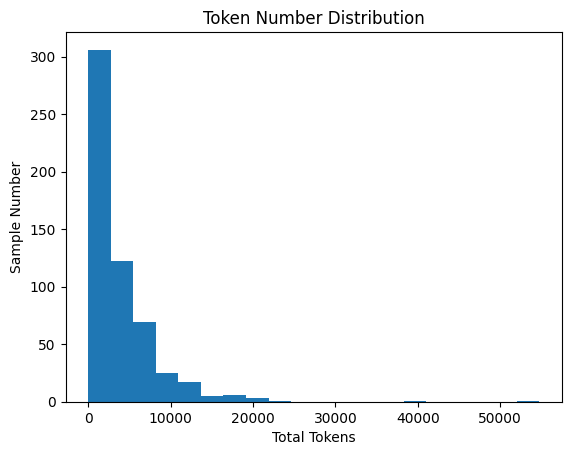

train_dataset records: (556, 3)
val_dataset records: (140, 3)
selected train_dataset records: (100, 3)
selected val_dataset records: (40, 3)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/40 [00:00<?, ? examples/s]

In [5]:
CREATE_NEW_TOKENIZED_DATASET = True

train_df = pd.read_csv(project_path + "/dataset/training.csv")
train_df.dropna(subset=['Text', 'Groundtruth'], inplace=True, axis=0)
val_df = pd.read_csv(project_path + "/dataset/eval.csv")
val_df.dropna(subset=['Text', 'Groundtruth'], inplace=True, axis=0)

text_len = train_df['Text'].str.len()
plt.hist(text_len, bins = 20)
plt.title("Token Number Distribution")
plt.xlabel("Total Tokens")
plt.ylabel("Sample Number")
plt.show()

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

print("train_dataset records:", train_dataset.shape)
print("val_dataset records:", val_dataset.shape)
train_dataset = train_dataset.select(range(100))
val_dataset = val_dataset.select(range(40))
print("selected train_dataset records:", train_dataset.shape)
print("selected val_dataset records:", val_dataset.shape)

if CREATE_NEW_TOKENIZED_DATASET:
    # tokenize the data te prepare for the training
    train_dataset = train_dataset.map(
        model_action.process_data_to_model_inputs,
        batched=True,
        batch_size=model_action.batchsize)

    val_dataset = val_dataset.map(
        model_action.process_data_to_model_inputs,
        batched=True,
        batch_size=model_action.batchsize)

    train_dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
    )
    val_dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
    )
    # save to disk: https://huggingface.co/docs/datasets/v1.5.0/processing.html#:~:text=You%20can%20save%20your%20dataset,objects%2C%20you%20can%20use%20datasets.
    train_dataset.save_to_disk(project_dataset_path + "/train_dataset/")
    val_dataset.save_to_disk(project_dataset_path + "/val_dataset/")

else:
    # load from the existing formmated tokenized dataset
    train_dataset = load_from_disk(project_dataset_path + "/train_dataset/")
    val_dataset = load_from_disk(project_dataset_path + "/val_dataset")

train_data_loader = DataLoader(train_dataset, batch_size = model_action.batchsize, shuffle=True,drop_last=True)
val_data_loader = DataLoader(val_dataset, batch_size = model_action.batchsize, shuffle=True,drop_last=True)

# 3. Fine-tune the Model and Save Check-point

The fine tune only occurs in the last layer: lm_head and final_logits_bias. All of the other layers' parameters are frozen.

There is early-exit mechanism. When the val_loss continues going up, stop the training process. The latest checkpoint model is saved to sub folder `Checkpoints`. All the training and verification loss, and rouge metrics are saved to folder `Runing_result`too.

In [6]:
num_epochs = 8
total_train_loss, total_val_loss, total_train_rouge, total_val_rouge = [], [], [], []
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
best_val_loss = float('inf')
#Declare variable for storing the checkpoint
checkpoint_filename = "LED_model_checkpoint.pt"
patience = 3

for epochi in tqdm(range(num_epochs)):
    val_batch_data_iter = iter(val_data_loader)
    train_loss, train_rouge = [], []
    val_loss, val_rouge = [], []
    for idx, data in tqdm(enumerate(train_data_loader)):
        ids = data['input_ids'].to(DEVICE)
        am = data['attention_mask'].to(DEVICE)
        gam = data['global_attention_mask'].to(DEVICE)
        labels = data['labels'].to(DEVICE)

        # freeze all the layers except the last layer lm_head
        model_action.model.train()
        for parameter in model_action.model.parameters():
            parameter.requires_grad = False
        for parameter in model_action.model.lm_head.parameters():
            parameter.requires_grad = True
        model_action.model.final_logits_bias.requires_grad = True

        # output = model_action.model(input_ids = ids, attention_mask = am, labels = labels, global_attention_mask = gam, use_cache = False)
        output = model_action.model(input_ids = ids, attention_mask = am, global_attention_mask = gam, labels = labels, use_cache = False)

        torch.device('cpu')
        loss = output.loss
        logits = output.logits

        print("epoch {}, batch {}, training loss: {}".format(epochi, idx, loss.item()))
        p_text = model_action.convert_logits_to_text(output.logits)[1:]
        e_text = model_action.convert_tokens_to_text(labels)
        model_action.log_generated_summary(epochi, e_text, p_text, f"training batch:{idx}")

        rouge1, rouge2, rougeL = model_action.calculate_rouge_scores(p_text, e_text)
        train_rouge.append((rouge1, rouge2, rougeL))

        # Backward and optimize
        model_action.optimizer.zero_grad()
        train_loss.append(loss.item())
        loss.backward()
        model_action.optimizer.step()

        # evaluate once every 20 mini-batches
        if idx > 0 and idx % 10 == 0:
            val_batch_data = next(iter(val_data_loader))

            # model. eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode. torch. no_grad() impacts the autograd engine and deactivate it.
            model_action.model.eval()
            with torch.no_grad():
                val_data = next(val_batch_data_iter)
                val_ids = val_data['input_ids'].to(DEVICE)
                val_am = val_data['attention_mask'].to(DEVICE)
                val_gam = val_data['global_attention_mask'].to(DEVICE)
                val_labels = val_data['labels'].to(DEVICE)
                val_output = model_action.model(input_ids = val_ids, attention_mask = val_am, labels = val_labels, global_attention_mask = val_gam, use_cache = False)

            torch.device('cpu')
            vloss = val_output.loss.item()
            val_loss.append(vloss)

            print("epoch {}, prediction loss: {}".format(epochi, vloss))
            # The first word is always a repeat, so delete it.
            pred_text = model_action.convert_logits_to_text(val_output.logits)[1:]
            exp_text = model_action.convert_tokens_to_text(val_labels)
            model_action.log_generated_summary(epochi, e_text, p_text, f"verification batch:{idx}")
            rouge1, rouge2, rougeL = model_action.calculate_rouge_scores(pred_text, exp_text)
            val_rouge.append((rouge1, rouge2, rougeL))
            print("\nprediction text:")
            display(pred_text)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)
    total_train_rouge.append(train_rouge)
    total_val_rouge.append(val_rouge)
    model_action.log_metrics(epochi, avg_train_loss, avg_val_loss, train_rouge, val_rouge)
    print("epoch {}'s average training loss: {}", np.mean(train_loss))
    print("epoch {}'s average verification loss: {}", np.mean(val_loss))

    # The following uses Sudha's code to stop training and save checkpoint when the val loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        model_action.save_model_checkpoint(checkpoint_filename)
        print("The checkpoint model is saved after finishing epoch {epochi}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered.")
            break

# save running result for evaluation
running_res_folder = project_path + "/Running_result"
if not os.path.exists(running_res_folder):
    os.mkdir(running_res_folder)

tt_loss = pd.DataFrame(total_train_loss)
tt_loss.to_csv(running_res_folder + "/total_train_loss.csv")
tv_loss = pd.DataFrame(total_val_loss)
tt_loss.to_csv(running_res_folder + "/total_val_loss.csv")

tt_train_rouge = pd.DataFrame(total_train_rouge)
tt_train_rouge.to_csv(running_res_folder + "/total_train_rouge.csv")
tt_val_rouge = pd.DataFrame(total_val_rouge)
tt_val_rouge.to_csv(running_res_folder + "/total_val_rouge.csv")


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

epoch 0, batch 0, training loss: 3.61143159866333



1it [00:05,  5.12s/it]

epoch 0, batch 1, training loss: 3.643406867980957



2it [00:08,  4.06s/it]

epoch 0, batch 2, training loss: 4.1581196784973145



3it [00:11,  3.78s/it]

epoch 0, batch 3, training loss: 3.6040360927581787



4it [00:15,  3.65s/it]

epoch 0, batch 4, training loss: 3.8111531734466553



5it [00:18,  3.59s/it]

epoch 0, batch 5, training loss: 4.106921672821045



6it [00:22,  3.54s/it]

epoch 0, batch 6, training loss: 3.6163923740386963



7it [00:25,  3.52s/it]

epoch 0, batch 7, training loss: 3.6028873920440674



8it [00:29,  3.50s/it]

epoch 0, batch 8, training loss: 3.682450771331787



9it [00:32,  3.49s/it]

epoch 0, batch 9, training loss: 3.732048273086548



10it [00:36,  3.49s/it]

epoch 0, batch 10, training loss: 3.6100430488586426
epoch 0, prediction loss: 3.4481613636016846

prediction text:


[' time timeadic time series motifs are determined by the relative magnitude and ordinal order of three data points that chosen from the time series. when times are different by the types types of on the data on full bythe study is from the horizontals of horizontal visibility graphs ( well considers not visibility and magn of the points as the to the between the series motifs explore the than structures of to the visibility graphs (s. x,, bbbbbbbbbbbbabababababbybyby)=()=()=(bbbbbbpbpbpbpbpbpbpbpb',
 ' we we sampling introduces a new probabilistically safe local steering primitive for sampling-based motion planning in complex high-dimensional con spaces, our proposed is based on a ax probabilistically safe corridors around tangent hyperplanes of cond intervalsipso- of gaussian mixture models learned from prior collision history. we using a random motion planning graph towards a sample goal using its onto prob prob, we proposed e exploitsages the geometry of guide proper steering direc


11it [00:40,  3.81s/it]

epoch 0, batch 11, training loss: 3.7802534103393555



12it [00:44,  3.66s/it]

epoch 0, batch 12, training loss: 3.8396079540252686



13it [00:47,  3.60s/it]

epoch 0, batch 13, training loss: 3.9204154014587402



14it [00:50,  3.56s/it]

epoch 0, batch 14, training loss: 4.204233169555664



15it [00:54,  3.53s/it]

epoch 0, batch 15, training loss: 3.7488744258880615



16it [00:57,  3.52s/it]

epoch 0, batch 16, training loss: 3.564725160598755



17it [01:01,  3.51s/it]

epoch 0, batch 17, training loss: 3.961836576461792



18it [01:04,  3.50s/it]

epoch 0, batch 18, training loss: 3.413154363632202



19it [01:08,  3.49s/it]

epoch 0, batch 19, training loss: 3.945551633834839



20it [01:11,  3.49s/it]

epoch 0, batch 20, training loss: 4.006403923034668
epoch 0, prediction loss: 3.9842629432678223

prediction text:


[' the the bre of a improved betation of the bremsstrahlung cross section of electron electron in the atomic electric field using the ordered ordered perturbative theory. the results are compared with the bethe-heitinler formula. which a strong screening parameter- dependent cross section, predicted for by previous bre.  results of the importance of the the-- and and a soft version for the the cross.  words : bremsstrahlung process timeed, time screening e. x                        ',
 ' we we rkn-type method is order p is the simpl for the regular problems,the simplifying assumptions are introduced for thekn methods crkn methods. and the assumption being legendre polynomials..the methodence of the r for the theorem of a crkn method is the p{p, +, +,is proved.den using the rodratic theorem to aation the of we method methodrkn method is obtained. the legendic rlynomial method.the method of the methodkn method is of in on the legend of the legendlynomial coefficients the legendrature of.


21it [01:16,  3.82s/it]

epoch 0, batch 21, training loss: 3.705491304397583



22it [01:19,  3.68s/it]

epoch 0, batch 22, training loss: 4.082788944244385



23it [01:23,  3.62s/it]

epoch 0, batch 23, training loss: 3.4851491451263428



24it [01:26,  3.58s/it]

epoch 0, batch 24, training loss: 3.840693473815918



25it [01:30,  3.61s/it]


epoch {}'s average training loss: {} 3.7871227931976317
epoch {}'s average verification loss: {} 3.7162121534347534


 12%|█▎        | 1/8 [01:53<13:11, 113.01s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 1, batch 0, training loss: 4.1153669357299805



1it [00:04,  4.48s/it]

epoch 1, batch 1, training loss: 4.287501811981201



2it [00:07,  3.90s/it]

epoch 1, batch 2, training loss: 4.011754989624023



3it [00:11,  3.72s/it]

epoch 1, batch 3, training loss: 3.6333727836608887



4it [00:14,  3.63s/it]

epoch 1, batch 4, training loss: 3.4667091369628906



5it [00:18,  3.58s/it]

epoch 1, batch 5, training loss: 3.9790239334106445



6it [00:21,  3.55s/it]

epoch 1, batch 6, training loss: 4.087514877319336



7it [00:25,  3.53s/it]

epoch 1, batch 7, training loss: 3.8476529121398926



8it [00:28,  3.51s/it]

epoch 1, batch 8, training loss: 3.5969176292419434



9it [00:32,  3.51s/it]

epoch 1, batch 9, training loss: 3.7919886112213135



10it [00:35,  3.51s/it]

epoch 1, batch 10, training loss: 4.059605598449707
epoch 1, prediction loss: 3.3021440505981445

prediction text:


[' the therom in bre ph in to bre of oons or nuclei in bre as bremsstrahlung. which second which in nearly branches of physics. recentlyhe and heitler ( a quantum-mechanical formula of themsstrahlung emission which to the bethe-heititler formula. which used in astroph electrom and astrophysics. recently, a puzzled puzzled of the-ray energy spectra of the validity. validity. in new bremsstrahlung formula is the potential is derived, where the ordered ordered perturbative theory to separate the and radiation processes atthe formula formula predicts',
 ' we we aim is a method for proving ahedral formulas for which on the case of the functions inoted by p and q, when is the importance necessary to prove a identity and which the the of and and and weightsetries of in method also discusses some to computing the and coefficients the equality of co co co. given cases of in is with discussing some practical complexity involved by proving proof of some a to furtherifying. , the text is the metho


11it [00:40,  3.84s/it]

epoch 1, batch 11, training loss: 3.492631435394287



12it [00:43,  3.69s/it]

epoch 1, batch 12, training loss: 3.59307599067688



13it [00:47,  3.64s/it]

epoch 1, batch 13, training loss: 3.158764123916626



14it [00:50,  3.60s/it]

epoch 1, batch 14, training loss: 3.6748383045196533



15it [00:54,  3.57s/it]

epoch 1, batch 15, training loss: 3.590085983276367



16it [00:57,  3.55s/it]

epoch 1, batch 16, training loss: 3.410536766052246



17it [01:01,  3.54s/it]

epoch 1, batch 17, training loss: 3.9265129566192627



18it [01:04,  3.53s/it]

epoch 1, batch 18, training loss: 3.8663792610168457



19it [01:08,  3.53s/it]

epoch 1, batch 19, training loss: 3.675159454345703



20it [01:11,  3.52s/it]

epoch 1, batch 20, training loss: 3.2179858684539795
epoch 1, prediction loss: 3.978102684020996

prediction text:


[' adaptive adaptive performance of the guided and adaptive - the - - r- )rt )plan adaptive dynamic ( both local and a real robot. in of evaluated by comparing the-rrt with several rrt planners andinussian mixture models ( learned online for collision generated the rrt planning and and and degrees sizes for for on the number data space andin gams learning is around for clusters collision,in-rrt is shown on a real humanoid robot and and that comp performance over a non performance to the r.  addition- performance (, the-rrt is that comp time and higher collision checks than to the rrt planners',
 ' we we aim on a concepts and lemmas for to the stability and hur thezler and hurwitz andand metagonally stable matrices,the is that between the mat properties and the ammas for the and of awitz and andzler matrices andthe, it is the description a smooth dynamical system and and as the of susceptible that susceptible to immun, and recovered, and well as the of to the recovery with the susceptib


21it [01:16,  3.85s/it]

epoch 1, batch 21, training loss: 3.7950847148895264



22it [01:19,  3.71s/it]

epoch 1, batch 22, training loss: 3.661559820175171



23it [01:23,  3.65s/it]

epoch 1, batch 23, training loss: 3.4449994564056396



24it [01:26,  3.60s/it]

epoch 1, batch 24, training loss: 3.5344223976135254



25it [01:30,  3.62s/it]


epoch {}'s average training loss: {} 3.716777830123901
epoch {}'s average verification loss: {} 3.6401233673095703


 25%|██▌       | 2/8 [03:28<10:16, 102.73s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 2, batch 0, training loss: 3.8122239112854004



1it [00:04,  4.09s/it]

epoch 2, batch 1, training loss: 3.6750879287719727



2it [00:07,  3.74s/it]

epoch 2, batch 2, training loss: 3.6464834213256836



3it [00:11,  3.64s/it]

epoch 2, batch 3, training loss: 3.6549956798553467



4it [00:14,  3.59s/it]

epoch 2, batch 4, training loss: 3.8293402194976807



5it [00:18,  3.57s/it]

epoch 2, batch 5, training loss: 3.362358331680298



6it [00:21,  3.56s/it]

epoch 2, batch 6, training loss: 3.9340903759002686



7it [00:25,  3.54s/it]

epoch 2, batch 7, training loss: 3.331737518310547



8it [00:28,  3.54s/it]

epoch 2, batch 8, training loss: 3.3808741569519043



9it [00:32,  3.53s/it]

epoch 2, batch 9, training loss: 3.1351912021636963



10it [00:35,  3.53s/it]

epoch 2, batch 10, training loss: 3.5884928703308105
epoch 2, prediction loss: 3.815767526626587

prediction text:


[' adaptive adaptive performance of the guided and adaptive - the walks - r- )rt )plan adaptive dynamic ( both local and a real robot. in measures evaluated by comparing the-rrt with several rrt planners andinussian mixture models ( learned online for collision generated the rrt planning and and and degrees sizes for for on the number data space andin gams learning is around for clusters collision,in-rrt is shown on a real humanoid robot and and that comp performance over a non performance to the r.  addition- performance (, the-rrt is that comp time and higher collision checks than to the rrt planners',
 ' a a sir proposes a node-based susceptibleiss epidemic model with complex networks with where the infective propagation and theoretical propagation is a asymptot stability of the endemic equilibrium and theoretical -ical and of the results that and that strong correlation between network degree and infected rate,the show that the network average average infected percentage are with t


11it [00:40,  3.87s/it]

epoch 2, batch 11, training loss: 3.084702968597412



12it [00:43,  3.72s/it]

epoch 2, batch 12, training loss: 3.201852560043335



13it [00:47,  3.66s/it]

epoch 2, batch 13, training loss: 4.3889360427856445



14it [00:50,  3.62s/it]

epoch 2, batch 14, training loss: 3.582180976867676



15it [00:54,  3.59s/it]

epoch 2, batch 15, training loss: 3.692124128341675



16it [00:57,  3.56s/it]

epoch 2, batch 16, training loss: 3.830979585647583



17it [01:01,  3.55s/it]

epoch 2, batch 17, training loss: 3.981184959411621



18it [01:04,  3.54s/it]

epoch 2, batch 18, training loss: 3.7965855598449707



19it [01:08,  3.54s/it]

epoch 2, batch 19, training loss: 3.60446834564209



20it [01:11,  3.53s/it]

epoch 2, batch 20, training loss: 3.5316596031188965
epoch 2, prediction loss: 3.4562184810638428

prediction text:


[' in in prove the attractivity of we system invariant set is to be determined for the system. to system consists {,, in, r,, rn, im)t|ii + ri, im, i =,, n} is an to be aant underthe as is shown as :z dd = g) with the cases of z of on the positiveplanes structure are the systemant set are discussed respectively to is shown that the system e the system is globally attractive on the. to asymptotic behavior of solutions of explored. d two functions functions as and)| f)  as e',
 ' in in concept is the advantages of numerical methods methods which preserve at features of aical systems with it with as symmlectic methods symmetric and and-preserving, invari invari integrators are presented. and of to a dynam with. itmmetric integrators are which,ge-kutta-, partition shown as reversible ability to preserve theibility and and to a long-time numerical behavior. -stage methods, also as theizations of traditional numerical -stage methods with and a of terms and numerical of it paper is includes t


21it [01:16,  3.85s/it]

epoch 2, batch 21, training loss: 4.209298133850098



22it [01:19,  3.70s/it]

epoch 2, batch 22, training loss: 3.3951148986816406



23it [01:23,  3.64s/it]

epoch 2, batch 23, training loss: 3.9101579189300537



24it [01:26,  3.60s/it]

epoch 2, batch 24, training loss: 3.4429385662078857



25it [01:30,  3.62s/it]


epoch {}'s average training loss: {} 3.6401223945617676
epoch {}'s average verification loss: {} 3.635993003845215


 38%|███▊      | 3/8 [05:03<08:16, 99.25s/it] 

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 3, batch 0, training loss: 3.294358015060425



1it [00:04,  4.61s/it]

epoch 3, batch 1, training loss: 3.7523341178894043



2it [00:08,  3.96s/it]

epoch 3, batch 2, training loss: 3.5546653270721436



3it [00:11,  3.76s/it]

epoch 3, batch 3, training loss: 3.2083590030670166



4it [00:15,  3.66s/it]

epoch 3, batch 4, training loss: 3.666790723800659



5it [00:18,  3.61s/it]

epoch 3, batch 5, training loss: 3.7569353580474854



6it [00:22,  3.58s/it]

epoch 3, batch 6, training loss: 3.340928792953491



7it [00:25,  3.56s/it]

epoch 3, batch 7, training loss: 3.559065103530884



8it [00:29,  3.55s/it]

epoch 3, batch 8, training loss: 4.864933013916016



9it [00:32,  3.54s/it]

epoch 3, batch 9, training loss: 3.079272747039795



10it [00:36,  3.53s/it]

epoch 3, batch 10, training loss: 3.6991848945617676
epoch 3, prediction loss: 3.2877097129821777

prediction text:


[' let letirillov-reshetikhin modules k )modules are an families of the quantum anine algebra uq(b g )in with the complex simple lie algebra.. the how a k module orposes into anreducible uq-modules is an fundamental problem in in the fermionic formula by killov and reshetikhin gives a explicit to it is not used to prove it, in kino removal rule is a explicit and for decom type g. but the polyhedral formula with for exceptional type g. but it with multiplicityities greater largely conjectural. in paper presents a method to',
 ' in in poly is thatorem that  showing that polyhedral formula for res = lie algebra of type f when a = or, a functions in t. the is a newhedral formula for a = for a the table of q m, of show the formula.the proof is a table of a and a froma the w. dis-invariant wthe the section, we weyl orbitator is = sub sub are explicitly explicitlythe, the is made to the accompanying to computing theyl orbits of cos minimal notebook for some computer calculations. -.. ggg     


11it [00:40,  3.87s/it]

epoch 3, batch 11, training loss: 3.8182547092437744



12it [00:44,  3.72s/it]

epoch 3, batch 12, training loss: 3.353400230407715



13it [00:47,  3.66s/it]

epoch 3, batch 13, training loss: 3.5185773372650146



14it [00:51,  3.61s/it]

epoch 3, batch 14, training loss: 4.127179145812988



15it [00:54,  3.59s/it]

epoch 3, batch 15, training loss: 3.7785282135009766



16it [00:58,  3.56s/it]

epoch 3, batch 16, training loss: 3.7211902141571045



17it [01:01,  3.55s/it]

epoch 3, batch 17, training loss: 3.738403081893921



18it [01:05,  3.54s/it]

epoch 3, batch 18, training loss: 3.7025277614593506



19it [01:08,  3.53s/it]

epoch 3, batch 19, training loss: 3.622274875640869



20it [01:12,  3.52s/it]

epoch 3, batch 20, training loss: 3.1189095973968506
epoch 3, prediction loss: 3.657827138900757

prediction text:


[' the therom in bre ph in to bre of proons or nuclei in bre as bremsstrahlung. which second which in nearly branches of physics. recentlyhe and heitler ( a quantum-mechanical formula of themsstrahlung emission which to the bethe-heititler formula. which used in astroph electrom and astrophysics. recently, a puzzled die of the-ray energy spectra of the validity. validity. in new bremsstrahlung formula is the potential is derived using where the ordered ordered perturbative theory to separate the and radiation processes atthe formula formula predicts',
 ' we we m is a computation complexity involved in the the poly of the rational identities for coted by c and d, we main for obtained explicitly the computer polyhedral formula for the the the functions inwe main d case arises when in the k sub, to case are carried on a computer and a a the weyl group w disets w check the denomin for then their the is d. we results is illustrated and and the computation of the numericalets and the computa


21it [01:16,  3.85s/it]

epoch 3, batch 21, training loss: 3.5471670627593994



22it [01:20,  3.70s/it]

epoch 3, batch 22, training loss: 3.091209888458252



23it [01:23,  3.64s/it]

epoch 3, batch 23, training loss: 3.8287150859832764



24it [01:27,  3.60s/it]

epoch 3, batch 24, training loss: 3.2946300506591797



25it [01:30,  3.64s/it]


epoch {}'s average training loss: {} 3.6015117740631104
epoch {}'s average verification loss: {} 3.4727684259414673


 50%|█████     | 4/8 [06:39<06:31, 97.90s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 4, batch 0, training loss: 4.0974440574646



1it [00:03,  3.82s/it]

epoch 4, batch 1, training loss: 4.021117687225342



2it [00:07,  3.64s/it]

epoch 4, batch 2, training loss: 3.7283549308776855



3it [00:10,  3.57s/it]

epoch 4, batch 3, training loss: 3.110077381134033



4it [00:14,  3.55s/it]

epoch 4, batch 4, training loss: 3.0690648555755615



5it [00:17,  3.54s/it]

epoch 4, batch 5, training loss: 3.471203565597534



6it [00:21,  3.53s/it]

epoch 4, batch 6, training loss: 3.646890878677368



7it [00:24,  3.52s/it]

epoch 4, batch 7, training loss: 3.277514696121216



8it [00:28,  3.52s/it]

epoch 4, batch 8, training loss: 3.2799999713897705



9it [00:31,  3.52s/it]

epoch 4, batch 9, training loss: 3.362175464630127



10it [00:35,  3.52s/it]

epoch 4, batch 10, training loss: 3.5261919498443604
epoch 4, prediction loss: 3.485187530517578

prediction text:


[' the the continuous-stage runkn method with a numerical method for for solve the value problems with by second second-order system with as is a extension over the r based it allows less storage and the the work compared compared as paper is based as a of is butcher tableau. which it with the numerical, solving the- and systems,the, the formal of is the continuousrkn method is proposed den and a counterpart of the classical rkn method.the... bbb         dddd  ddab   ddddadababababababab',
 ' symm symm construction of symm construction of symmetric integrators for continuous-stage runge-kutta-nyystr omm ( for solving systems on in constructionrators are based on solving second-order ordinary die equations on and there expansion technique in with symmetric conditions and simplifying assumptions for order conditions. new construction also the families of symmetric integrators as illust illust experiments to illustrate the numerical behaviors.  words : continuous-stage runge-kutta-nyström


11it [00:40,  3.86s/it]

epoch 4, batch 11, training loss: 3.5988736152648926



12it [00:43,  3.71s/it]

epoch 4, batch 12, training loss: 3.681891441345215



13it [00:46,  3.65s/it]

epoch 4, batch 13, training loss: 3.5206124782562256



14it [00:50,  3.61s/it]

epoch 4, batch 14, training loss: 3.587183952331543



15it [00:53,  3.58s/it]

epoch 4, batch 15, training loss: 3.39093017578125



16it [00:57,  3.56s/it]

epoch 4, batch 16, training loss: 3.444295883178711



17it [01:01,  3.55s/it]

epoch 4, batch 17, training loss: 3.3275718688964844



18it [01:04,  3.54s/it]

epoch 4, batch 18, training loss: 3.2906172275543213



19it [01:08,  3.53s/it]

epoch 4, batch 19, training loss: 3.215571641921997



20it [01:11,  3.52s/it]

epoch 4, batch 20, training loss: 3.892331123352051
epoch 4, prediction loss: 3.7815775871276855

prediction text:


[' in in this paper, we results are performed to compare the numerical of the symm for for symmetric symmkn methods are presented for the to the perturbed pendulum equation with for show that the theetric r are be nearly preserve the over long times of theylectic-stural methods are more for long -term numerical simulation of general nonian systems. formmetric methods are more for general reversible non -hamian systems. in - this,,,,,,bbbbbddbbabddddabababddpbbbbpbpbpbpbbpbpbpbpbpbpbpbpbpb',
 ' a a spread proposes a node-based susceptibleiss epidemic model with complex networks with where the infective propagation and theoretical propagation is a asymptot stability of the endemic equilibrium and theoretical.ical and of the results that and that strong correlation between network degree and infected rate,the show that the network average average infected percentage are with the increase rate of media epidemicive media and the stable by the spread and infectedivity and the- connected netw


21it [01:16,  3.85s/it]

epoch 4, batch 21, training loss: 3.7182252407073975



22it [01:19,  3.70s/it]

epoch 4, batch 22, training loss: 3.2881827354431152



23it [01:23,  3.65s/it]

epoch 4, batch 23, training loss: 3.5217623710632324



24it [01:26,  3.60s/it]

epoch 4, batch 24, training loss: 3.7460360527038574



25it [01:30,  3.60s/it]
 62%|██████▎   | 5/8 [08:09<04:45, 95.08s/it]

epoch {}'s average training loss: {} 3.512564849853516
epoch {}'s average verification loss: {} 3.633382558822632



0it [00:00, ?it/s]

epoch 5, batch 0, training loss: 3.428086519241333



1it [00:03,  3.49s/it]

epoch 5, batch 1, training loss: 3.170328140258789



2it [00:07,  3.51s/it]

epoch 5, batch 2, training loss: 3.1978976726531982



3it [00:10,  3.51s/it]

epoch 5, batch 3, training loss: 3.6219520568847656



4it [00:14,  3.51s/it]

epoch 5, batch 4, training loss: 3.721456289291382



5it [00:17,  3.51s/it]

epoch 5, batch 5, training loss: 3.4011173248291016



6it [00:21,  3.51s/it]

epoch 5, batch 6, training loss: 3.9012489318847656



7it [00:24,  3.51s/it]

epoch 5, batch 7, training loss: 3.4518237113952637



8it [00:28,  3.51s/it]

epoch 5, batch 8, training loss: 3.7041542530059814



9it [00:31,  3.51s/it]

epoch 5, batch 9, training loss: 3.654205083847046



10it [00:35,  3.51s/it]

epoch 5, batch 10, training loss: 3.4775867462158203
epoch 5, prediction loss: 3.2346649169921875

prediction text:


[' in in study introduces a new probabilistically safe local steering primitive for sampling-based motion planning in complex high-dimensional con spaces based our proposed is based on a ax probabilistically safe corridors around tangent hyperplanes of cond intervalsipso- of gaussian mixture models learned from prior collision history. we using a random motion planning graph towards a sample goal using its onto prob prob, we proposed e exploitsages the geometry of guide proper steering direction and adapt steering stepsize. we proposed local method is evaluated to be effective steering around d regions of narrow passages and minimizing collision likelihood.  of simulation planning scenarios with both simulation and on',
 ' symm symmmmetric integ are numerical numerical of numericalrsk are are the certain conditions for a of in numerical one-step method is called symmetric if it sat the conditions. are that symmetry method and the adjoint method give identical numerical. in conditions f


11it [00:39,  3.85s/it]

epoch 5, batch 11, training loss: 3.509800910949707



12it [00:43,  3.70s/it]

epoch 5, batch 12, training loss: 3.43264102935791



13it [00:46,  3.64s/it]

epoch 5, batch 13, training loss: 3.82358717918396



14it [00:50,  3.61s/it]

epoch 5, batch 14, training loss: 3.140645742416382



15it [00:53,  3.57s/it]

epoch 5, batch 15, training loss: 3.141505718231201



16it [00:57,  3.55s/it]

epoch 5, batch 16, training loss: 3.6260035037994385



17it [01:00,  3.54s/it]

epoch 5, batch 17, training loss: 3.344977378845215



18it [01:04,  3.53s/it]

epoch 5, batch 18, training loss: 3.232758045196533



19it [01:07,  3.52s/it]

epoch 5, batch 19, training loss: 3.4259095191955566



20it [01:11,  3.52s/it]

epoch 5, batch 20, training loss: 3.3704686164855957
epoch 5, prediction loss: 3.4786529541015625

prediction text:


[' in in continuous on the-stage runge-kutta-nyystr omm methods and their applications parameter inin is the the notion of the some results which are in constructing such of arbitrarily order ininch --@@@,gngngngnibibgnadadgnibgdgdgdgdgdgdgdgdgdgdbbivalentgdgdpbivalentivalentddgdddababababadjadjababababadenababababababababababababababababababababababababababababababababab',
 ' time time proposed of a new to tri series class based on triadic time series motifs and we types of tris are proposed and investigated in and are extracted from log types maps and based analyzing the occurrence with we of are different time series are be estimated and and to classification classification of based proposed is applied on the ucr time series class archive and provides evidence classification than the dynamic time wrappingping method some data.  words : : series motif, time, motif analysis, dynamic dynamic time wrappingping. k..bbbbddddddddddddddddddddddddddddabdd',
 ' we we modules form areducible n


21it [01:15,  3.85s/it]

epoch 5, batch 21, training loss: 3.6731929779052734



22it [01:19,  3.70s/it]

epoch 5, batch 22, training loss: 3.3984782695770264



23it [01:22,  3.65s/it]

epoch 5, batch 23, training loss: 3.68205189704895



24it [01:26,  3.60s/it]

epoch 5, batch 24, training loss: 3.1801438331604004



25it [01:29,  3.59s/it]


epoch {}'s average training loss: {} 3.4684808540344236
epoch {}'s average verification loss: {} 3.356658935546875


 75%|███████▌  | 6/8 [09:44<03:09, 94.93s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 6, batch 0, training loss: 3.3535265922546387



1it [00:04,  4.61s/it]

epoch 6, batch 1, training loss: 3.188161849975586



2it [00:08,  3.97s/it]

epoch 6, batch 2, training loss: 3.3052430152893066



3it [00:11,  3.76s/it]

epoch 6, batch 3, training loss: 3.557513952255249



4it [00:15,  3.66s/it]

epoch 6, batch 4, training loss: 3.5338077545166016



5it [00:18,  3.60s/it]

epoch 6, batch 5, training loss: 3.2852227687835693



6it [00:22,  3.58s/it]

epoch 6, batch 6, training loss: 3.4955482482910156



7it [00:25,  3.55s/it]

epoch 6, batch 7, training loss: 3.8289804458618164



8it [00:29,  3.54s/it]

epoch 6, batch 8, training loss: 3.3129844665527344



9it [00:32,  3.53s/it]

epoch 6, batch 9, training loss: 3.5324923992156982



10it [00:36,  3.53s/it]

epoch 6, batch 10, training loss: 3.4316327571868896
epoch 6, prediction loss: 3.4140002727508545

prediction text:


[' in in continuous on the-stage runge-kutta-nyystr omm methods and their applications parameter inin is the the notion of the some results which are in constructing such of arbitrarily order ininch --@@@,gngngngnibibgnadadgnibgdgdgdgdgdgdgdgdgdgdbbivalentgdgdpbivalentivalentddgdddababababadjadjababababadenababababababababababababababababababababababababababababibabababab',
 ' in in prove the attractivity of we system invariant set is to be determined for a system. to system consists {,, in, r,, rn, im)t|ii + ri, im, i =,, n} is an to be aant underto as is shown as :z dd = g) with the cases of z of on the positiveplanes structure are the systemant set are discussed respectively to is shown that the system e the system is globally attractive on {}. to asymptotic behavior of solutions of explored by d two functions functions as and)| f) both as e',
 ' in in concept is the advantages of numerical methods methods which preserve at features of aical systems with it with as symmlectic method


11it [00:40,  3.86s/it]

epoch 6, batch 11, training loss: 3.7438859939575195



12it [00:44,  3.71s/it]

epoch 6, batch 12, training loss: 3.0432071685791016



13it [00:47,  3.65s/it]

epoch 6, batch 13, training loss: 3.4355738162994385



14it [00:51,  3.61s/it]

epoch 6, batch 14, training loss: 2.8275694847106934



15it [00:54,  3.58s/it]

epoch 6, batch 15, training loss: 3.5297579765319824



16it [00:58,  3.56s/it]

epoch 6, batch 16, training loss: 3.5498807430267334



17it [01:01,  3.54s/it]

epoch 6, batch 17, training loss: 3.525481700897217



18it [01:05,  3.54s/it]

epoch 6, batch 18, training loss: 2.670114040374756



19it [01:08,  3.53s/it]

epoch 6, batch 19, training loss: 4.020702838897705



20it [01:12,  3.52s/it]

epoch 6, batch 20, training loss: 3.7514455318450928
epoch 6, prediction loss: 3.0494790077209473

prediction text:


[' let let poly is a concepthedral formula for the decomposition of kr modules, the form of the integral weights forlet is the f of a integers j dominant j the n set of and a formula for the decomposition of the- andnomial.in formulaermionic formula is used to decompose the k of the zx to a in can the form decom.the f also a use for a proof argument of to prove the poly. the m values of m. in.,....   iiiiiiiii  }\\     d  abdbabab',
 ' we we poly of a method to prove a polyhedral branching formula for killov- reshetikhin modules over a quantum anine algebra. when method is which conjectural, the type lie algebras, is proved into an identity between two functions of a single variable with by identity isifies the proof of by a theities of the at known locations locations. by using this strategy, we computer provides a computer-assisted proof of a conjectural polyhedral formula in type f. -...,                      ',
 ' in in design of a prob steering approach for sampling- based motion 


21it [01:16,  3.85s/it]

epoch 6, batch 21, training loss: 3.3844313621520996



22it [01:20,  3.70s/it]

epoch 6, batch 22, training loss: 3.0963919162750244



23it [01:23,  3.64s/it]

epoch 6, batch 23, training loss: 3.749728202819824



24it [01:27,  3.60s/it]

epoch 6, batch 24, training loss: 3.379984140396118



25it [01:30,  3.63s/it]


epoch {}'s average training loss: {} 3.4213307666778565
epoch {}'s average verification loss: {} 3.231739640235901


 88%|████████▊ | 7/8 [11:19<01:35, 95.16s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 7, batch 0, training loss: 3.06221866607666



1it [00:03,  3.63s/it]

epoch 7, batch 1, training loss: 3.524139881134033



2it [00:07,  3.55s/it]

epoch 7, batch 2, training loss: 3.275552749633789



3it [00:10,  3.54s/it]

epoch 7, batch 3, training loss: 3.813321590423584



4it [00:14,  3.52s/it]

epoch 7, batch 4, training loss: 3.0654077529907227



5it [00:17,  3.52s/it]

epoch 7, batch 5, training loss: 3.338245391845703



6it [00:21,  3.52s/it]

epoch 7, batch 6, training loss: 2.941864252090454



7it [00:24,  3.52s/it]

epoch 7, batch 7, training loss: 3.0206871032714844



8it [00:28,  3.53s/it]

epoch 7, batch 8, training loss: 3.462301731109619



9it [00:31,  3.52s/it]

epoch 7, batch 9, training loss: 3.4967775344848633



10it [00:35,  3.52s/it]

epoch 7, batch 10, training loss: 3.2207982540130615
epoch 7, prediction loss: 3.671844720840454

prediction text:


[' time time series motif is theifying the similarity of two series and which is a for explor time in the time to as theuclidean distance and correlation time warping ( widely to measure similarity between but the time warping being being a performance than the a optimization to in series motifs are which the subsequences in time series data are useful to exploratory data mining and often of. inadic time series motifs are which by network motifs in horizontal visibility graphs, are useful used in discover time time data and in have used timeadic time series motifs to discover the rates of heart market dynamics, and the time series generated com',
 ' a a spread proposes a node-based susceptibleiss epidemic model with complex networks with where the infective propagation and theoretical propagation is a asymptot stability of the endemic equilibrium and theoretical.ical simulations of the results that and that strong correlation between network degree and infected rate,the show that the n


11it [00:39,  3.86s/it]

epoch 7, batch 11, training loss: 3.766258716583252



12it [00:43,  3.72s/it]

epoch 7, batch 12, training loss: 3.0015134811401367



13it [00:46,  3.66s/it]

epoch 7, batch 13, training loss: 3.1536941528320312



14it [00:50,  3.62s/it]

epoch 7, batch 14, training loss: 3.9096648693084717



15it [00:53,  3.59s/it]

epoch 7, batch 15, training loss: 3.5581886768341064



16it [00:57,  3.57s/it]

epoch 7, batch 16, training loss: 3.1830387115478516



17it [01:00,  3.55s/it]

epoch 7, batch 17, training loss: 3.2470529079437256



18it [01:04,  3.54s/it]

epoch 7, batch 18, training loss: 3.2748711109161377



19it [01:07,  3.53s/it]

epoch 7, batch 19, training loss: 3.3959693908691406



20it [01:11,  3.52s/it]

epoch 7, batch 20, training loss: 3.1838085651397705
epoch 7, prediction loss: 4.152740955352783

prediction text:


[' adaptive adaptive rapid of the guided and adaptive iter the access - r- )rt )plan adaptive dynamic ( both local and a real robot. in measures evaluated by comparison the-rrt with several rrt planners andinussian mixture models ( learned online for collision generated the rrt planning and and and degrees sizes for for on the number data space andin gams learning is around for clusters collision andin-rrt is shown on a real humanoid robot and and that comp performance with a non performance to the r.g addition- performance (, g-rrt is a comp time and higher collision checks compared to the rrt planners',
 ' in in concept is the advantages of numerical methods methods which preserve at features of aical systems with it with as symmlectic methods symmetric and volume-preserving, invari energy-rators are presented. and of to a dynam with. itmmetric integrators are which,ge-kutta- and are shown as reversible ability to preserve theibility and and to a long-time numerical behavior. in-stag


21it [01:16,  3.85s/it]

epoch 7, batch 21, training loss: 3.159334421157837



22it [01:19,  3.71s/it]

epoch 7, batch 22, training loss: 3.6742279529571533



23it [01:22,  3.65s/it]

epoch 7, batch 23, training loss: 3.97924542427063



24it [01:26,  3.60s/it]

epoch 7, batch 24, training loss: 3.7098803520202637



25it [01:29,  3.60s/it]
100%|██████████| 8/8 [12:49<00:00, 96.22s/it]


epoch {}'s average training loss: {} 3.3767225456237795
epoch {}'s average verification loss: {} 3.9122928380966187


# 4. Inference: Test PDF Summarization
Load a CSV file from `processed` folder. This CSV file is created after running `processing_pdf.jpynb`. The text of sections, subsections, subsubsections are put in different rows and marked with section number and section titles.

Use your own CSV file name to replace the sample `1901.00936v3.csv`.

In [7]:
pdf_df = pd.read_csv(project_processed_data_path + "/1901.00936v3.csv")

print("Start generating summary...")
generated_df = model_action.generate_summary_for_user_pdf(pdf_df)
display(generated_df.head())


Start generating summary...


,text,section_num:,section,subsection,generated
0,"an efficient linux kernel implementation of service function chaining for legacy vnfs based on ipv6 segment routing andrea mayer*, stefano salsano*, pier luigi ventre*, ahmed abdelsalam {double dagger} {section sign}, luca chiaraviglio*, clarence filsfils {section sign} *university of rome tor vergata, cnit, {double dagger}gran sasso science institute, {section sign}cisco systems extended version of the paper accepted to ieee netsoft 2019 - v04 - july 2019 abstract {em dash}we consider the ipv6 segment routing technology for service function chaining of virtual network functions . most of the vnfs are legacy vnfs and expect to process traditional ip packets. an sr proxy is needed to support them. we have extended the implementation of srv6 in the linux kernel, realizing an open source sr-proxy, referred to as srnk . the performance of the proposed solution has been evaluated, identifying a poor scalability with respect to the number of vnfs to be supported in a node. therefore we p...",Abstract,Abstract,NaN,"we consider the ipv6 segment routing technology for service function chaining of virtual network functions ( vnfs ). \n most of the vnfs are legacy vnfs and expect to process traditional ip packets. \n an sr proxy is needed to support them. we have extended the implementation of srv6 in the linux kernel, realizing an open source sr-proxy, referred to as srnk. \n the performance of the proposed solution has been evaluated, identifying a poor scalability with respect to the number of vnfs to be supported in a node. therefore we provided a second design, enhancing the linux policy routing framework. \n the performance of srnkv2 is independent from the number of supported vnfs in a node. we compared the performance of srnkv2 with a reference scenario not performing the encapsulation and decapsulation operation and demonstrated that the overhead of srnkv2 is very small, on the order of 3.5%."
1,"network operators are facing difficult challenges to keep up with the increasing demand for capacity, the need to support fast service creation and at the same time the goal of reducing the costs. network function virtualization and software defined networking represent an answer to these challenges and are changing the way ip networks are designed and operated. leveraging cloud computing principles, nfv moves the traditional data-plane network functions from expensive, closed and proprietary hardware to the so-called virtual network functions running over a distributed, cloud-like infrastructure referred to as nfvi . the sdn architecture splits the data and control planes and moves the intelligence to the sdn controller. sdn aims at simplifying the introduction of new services and fostering flexibility thanks to the centralized network state view. the concept of services chaining is directly associated to nfv. actually, the idea of creating a processing path across services pre-da...",I,I. INTRODUCTION,NaN,"the ietf sfc working group has investigated the scenarios and issues related to dynamic service chaining and proposed a reference architecture. \n the sfc framework proposed in does not pose any restriction on the function that can be chained: they can be both virtualized or physical functions. for the sake of simplicity, \n we will only refer to the virtualized case and will simply use the term vnf instead of service function. the ietf sfc wg is considering the network service header as a specific solution for the realization of the sfc architecture. the nsh header defines the service-level data-plane encapsulation for realizing the vnfs chaining. moreover, it defines the packet meta-data that arxiv:1901.00936v3 23 jul 2019 can be inserted into the header to exchange state between the nodes of the sfc architecture. in this work we are advocating the use of ipv6 segment routing to implement service function chaining,. segment routing, is a form of source routing, which allows to ad.